# Markov Chain-Based Financial Prediction System

## Overview
This system utilizes **Markov chains** to model the transition probabilities between states, calculate the expected value of each state, and predict outcomes. If the predicted value exceeds a predefined threshold, an order is executed.

## Mathematical Description

### State Transition Probability
The probability of transitioning from state $ i $ to state $ j $ is denoted by $ P_{ij} $, where:

$$ P_{ij} = \frac{\text{Number of transitions from } i \text{ to } j}{\text{Total transitions from } i} $$

### Expected Value of a State
The expected value $ E(s_i) $ of a state $ s_i $ is calculated as:

$$ E(s_i) = \sum_{j=1}^{n} P_{ij} \cdot V_j $$

where $ V_j $ is the value of transitioning to state $ j $ and $ n $ is the total number of possible transitions from $ s_i $.

### Threshold-Based Decision Making
A threshold value $ \theta $ is set, and if $ O(s_i) > \theta $, an order is placed:

$$
\text{if } O(s_i) > \theta \text{ then}
\begin{cases}
\text{Buy order executed} & \text{if prediction is positive} \\
\text{Sell order executed} & \text{if prediction is negative}
\end{cases}
$$

### Outcome Analysis
After executing orders, the final outcome is analyzed to assess the performance of the system.




In [27]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re 
import pandas as pd
import numpy as np
import datetime
from random import randint
import pandas as pd
import talib as talib

# gspc_df=pd.read_csv('data/google-2024-2004_day.csv',index_col=0)
gspc_df=pd.read_csv('data/google-2024-2004_day.csv')
gspc_df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']


The data here is the stock prices for Google for last 20 year, collected through alpha_vantage API and was saved as csv file. This data is loaded for this notebook.

In [28]:
gspc_df['Date'] = pd.to_datetime(gspc_df['Date'])

# cut_off_date = '2010-01-01' 
# gspc_df = gspc_df[gspc_df['Date'] >= cut_off_date].sort_values('Date')
gspc_df.sort_values('Date',inplace=True)
gspc_df.reset_index(drop=True, inplace=True)
gspc_df

,Date,Open,High,Low,Close,Volume
0,2004-08-19,100.010,104.06,95.960,100.335,44659000.0
1,2004-08-20,101.010,109.08,100.500,108.310,22834300.0
2,2004-08-23,110.760,113.48,109.050,109.400,18256100.0
3,2004-08-24,111.240,111.60,103.570,104.870,15247300.0
4,2004-08-25,104.760,108.00,103.880,106.000,9188600.0
...,...,...,...,...,...,...
4972,2024-05-21,176.900,178.15,175.810,177.850,16989369.0
4973,2024-05-22,176.644,177.15,175.210,176.380,17880042.0
4974,2024-05-23,177.070,178.25,172.950,173.550,21024935.0
4975,2024-05-24,174.980,175.77,173.650,174.990,16579438.0


## Technical Indicators Calculation
- `close`: Extracts the closing prices from the `gspc_df` DataFrame as numpy array. This is required for talib library.
- `Short_EMA`: Calculates the Exponential Moving Average (EMA) over a short window (14 days) of the closing prices.
- `Long_EMA`: Calculates the EMA over a longer window (50 days) of the closing prices.
- `RSI`: Computes the Relative Strength Index (RSI) for a 14-day period, indicating overbought or oversold conditions.

## State Determination and Percentage Change
- `Close_Gap`: Determines the percentage change in the closing prices from one period to the next.
- `State`: Assigns a binary state based on the sign of `Close_Gap`; `1` for positive changes (indicating an increase in price), and `0` for non-positive changes.
- `Short_EMA_Gap`: Calculates the percentage change in the short-term EMA, reflecting recent price trends.
- `Long_EMA_Gap`: Calculates the percentage change in the long-term EMA, reflecting more established price trends.


In [30]:
close = gspc_df['Close'].values
gspc_df['Short_EMA']=talib.EMA(close,14)
gspc_df['Long_EMA']=talib.EMA(close,50)
gspc_df['RSI']=talib.RSI(close,14)

# Calculate percentage changes in 'Close', 'High', 'Low', and 'Volume' columns
gspc_df['Close_Gap'] = gspc_df['Close'].pct_change()
gspc_df['State'] = [1 if x > 0 else 0 for x in gspc_df['Close_Gap']]
gspc_df['Short_EMA_Gap'] = gspc_df['Short_EMA'].pct_change()
gspc_df['Long_EMA_Gap'] = gspc_df['Long_EMA'].pct_change()



Any row containing Nan data is dropped, this Nan rows are caused by iterative row calculations, for example EMA:50 Days

In [31]:
gspc_df.dropna(how='any',inplace=True) 
print(gspc_df.shape)
gspc_df.tail(5)

(4927, 13)


,Date,Open,High,Low,Close,Volume,Short_EMA,Long_EMA,RSI,Close_Gap,State,Short_EMA_Gap,Long_EMA_Gap
4972,2024-05-21,176.900,178.15,175.810,177.85,16989369.0,171.397714,160.607253,72.139527,0.005257,1,0.005825,0.004401
4973,2024-05-22,176.644,177.15,175.210,176.38,17880042.0,172.062019,161.225792,68.169115,-0.008265,0,0.003876,0.003851
4974,2024-05-23,177.070,178.25,172.950,173.55,21024935.0,172.260417,161.709094,61.187168,-0.016045,0,0.001153,0.002998
4975,2024-05-24,174.980,175.77,173.650,174.99,16579438.0,172.624361,162.229914,63.249744,0.008297,1,0.002113,0.003221
4976,2024-05-28,174.450,177.27,174.365,176.40,20572157.0,173.127780,162.785603,65.199845,0.008058,1,0.002916,0.003425


# Event Pattern Generation

### Function: `categorize_gap`
- **Purpose**: Categorizes the gaps into high and low for positive and negative changes.
- **Parameters**:
  - `df`: The DataFrame to process.
  - `column_name`: The name of the column to categorize.
- **Process**:
  1. Initializes a new column with 'Neutral' for non-positive values.
  2. Defines labels for positive ('IL' for low, 'IH' for high) and negative ('DL' for low, 'DH' for high) changes.
  3. Identifies indices where the column values are positive or non-positive.
  4. Applies quantile-based discretization (qcut) to categorize the data into two bins for each subset.
- **Returns**: A Series with categorized values appended with '_LMH'.

### Application of `categorize_gap`
- The function is applied to 'Short_EMA_Gap' and 'Long_EMA_Gap' columns in `gspc_df` to create 'Short_EMA_Gap_LMH' and 'Long_EMA_Gap_LMH'.

### RSI Signal Determination
- `RSI_Signal`: Generates signals based on RSI values ('OB' for overbought, 'OS' for oversold, 'N' for neutral).

### Creation of `new_set_df`
- A new DataFrame `new_set_df` is created, containing selected columns from `gspc_df`.
- `Event_Pattern`: A new column concatenating the strings of 'Short_EMA_Gap_LMH', 'Long_EMA_Gap_LMH', and 'RSI_Signal' to form a pattern for each event.

In [32]:
def categorize_gap(df, column_name):
    # Create a new column initialized with 'Neutral' for zero or lower values
    df[column_name + '_LMH'] = 'Neutral'
    
    # Define the labels for the positive and negative categories
    labels_positive = ["IL", "IH"]
    labels_negative = ["DL", "DH"]
    
    # Identify the indices for positive and negative gaps
    positive_indices = df[df[column_name] > 0].index
    negative_indices = df[df[column_name] <= 0].index
    
    # Apply qcut to the positive and negative subsets using .loc
    if not positive_indices.empty:
        df.loc[positive_indices, column_name + '_LMH'] = pd.qcut(df.loc[positive_indices, column_name], 2, labels=labels_positive)
    if not negative_indices.empty:
        df.loc[negative_indices, column_name + '_LMH'] = pd.qcut(-df.loc[negative_indices, column_name], 2, labels=labels_negative)
    
    # Return the updated DataFrame
    return df[column_name + '_LMH']

# Apply the function to the 'Close_Gap' column
gspc_df['Short_EMA_Gap_LMH'] = categorize_gap(gspc_df, 'Short_EMA_Gap')
gspc_df['Long_EMA_Gap_LMH'] = categorize_gap(gspc_df, 'Long_EMA_Gap')
gspc_df['RSI_Signal'] = ['OB' if x > 70 else 'OS' if x < 30 else 'N' for x in gspc_df['RSI']]
# new set
new_set_df = gspc_df[[  "Date", 
                        "Close_Gap", 
                        "Short_EMA_Gap_LMH", 
                        "Long_EMA_Gap_LMH", 
                        "State",
                        'RSI_Signal']].copy()



new_set_df['Event_Pattern'] = new_set_df['Short_EMA_Gap_LMH'].astype(str) + new_set_df['Long_EMA_Gap_LMH'].astype(str) + new_set_df['RSI_Signal'].astype(str)

In [33]:
new_set_df.tail(5)

,Date,Close_Gap,Short_EMA_Gap_LMH,Long_EMA_Gap_LMH,State,RSI_Signal,Event_Pattern
4972,2024-05-21,0.005257,IH,IH,1,OB,IHIHOB
4973,2024-05-22,-0.008265,IH,IH,0,N,IHIHN
4974,2024-05-23,-0.016045,IL,IH,0,N,ILIHN
4975,2024-05-24,0.008297,IL,IH,1,N,ILIHN
4976,2024-05-28,0.008058,IL,IH,1,N,ILIHN


All the unique states are extracted:

In [34]:
print('The states are:')
print(new_set_df['Event_Pattern'].unique())
unique_patterns= new_set_df['Event_Pattern'].unique()
print('\nTotal unique pattern number is: ', len(unique_patterns))

The states are:
['IHIHOB' 'IHIHN' 'DHIHN' 'ILIHN' 'DLIHN' 'DHILN' 'DHDLN' 'DLILN' 'ILILN'
 'DLDLN' 'DHDHN' 'ILDLN' 'IHILN' 'DHDHOS' 'DLDHN' 'ILDHN' 'IHDLN' 'ILIHOB'
 'IHDHN' 'DLDHOS' 'IHILOB' 'ILILOB' 'ILDHOS']

Total unique pattern number is:  23


The dataset is split into training and validation, selected split is %90

In [35]:
# Calculate the split index, ensuring it's an integer
split_index = int(len(new_set_df) * 0.9)

# Create the training set using the calculated split index
training = new_set_df[:split_index]

# Create the validation set using the calculated split index
validation = new_set_df[split_index:]


# Construction of the Transition Grid

## Function: `build_transition_grid`
- **Objective**: To construct a stochastic matrix representing the transition probabilities between observed states and to calculate the expected value change associated with each transition.

1. **Initialization**:
   - Let $ \mathcal{P} $ be the set of all unique patterns.
   - Let $ \mathcal{T} $ be the transition grid to be constructed, initially empty.

2. **Transition Counting**:
   - For each pair of states $ (s_i, s_j) \in \mathcal{P} \times \mathcal{P} $, count the number of transitions from state $ s_i $ to state $ s_j $ in the dataset.
   - Denote the count of transitions from $ s_i $ to $ s_j $ as $ c_{ij} $.

3. **Expected Value Change Calculation**:
   - For each transition from $ s_i $ to $ s_j $, calculate the average change in the 'Close_Gap' value, denoted as $ \Delta_{ij} $.
   - If $ c_{ij} > 0 $, then 
   $ \Delta_{ij} = \frac{\sum \text{'Close\_Gap'}_{ij}}{c_{ij}}, \text{ otherwise } \Delta_{ij} = 0 $.

4. **Grid Construction**:
   - Construct a DataFrame $ \mathcal{G} $ with entries $ g_{ij} $ representing the counts $ c_{ij} $.
   - Normalize $ \mathcal{G} $ row-wise to obtain the transition probabilities $ P_{ij} = \frac{g_{ij}}{\sum_{j} g_{ij}} $.

5. **Change Grid Construction**:
   - Construct a DataFrame $ \mathcal{C} $ with entries $ \Delta_{ij} $ representing the expected value changes for each transition.

### Output
- The function returns two DataFrames:
  - $ \mathcal{T} $, the transition probability grid.
  - $ \mathcal{C} $, the expected value change grid.

These grids serve as the foundational matrices for the Markov chain model, enabling the prediction of state transitions and the quantification of their expected outcomes.




In [36]:
def build_transition_grid(dataset, unique_patterns):
    # Initialize lists to store pattern pairs and their counts
    patterns = []
    counts = []

    # List for patterns and value change
    change=0
    patterns2 =[]
    changes_list = []

    # Loop through each unique pattern as the 'from' event
    for from_event in unique_patterns:
        # Loop through each unique pattern as the 'to' event
        for to_event in unique_patterns:
            # Create a pattern string representing the transition from 'from_event' to 'to_event'
            pattern = from_event + ',' + to_event

            
            # Find the indices where the 'Event_Pattern' matches the 'from_event'
            from_event_indices = dataset[dataset['Event_Pattern'] == from_event].index
            # print(ids_matches)

            # Initialize count for the current pattern
            found = 0
            
            # Count occurrences of the transition from 'from_event' to 'to_event'
            for idx in from_event_indices:
                if idx + 1 < len(dataset) and dataset['Event_Pattern'].iloc[idx + 1] == to_event:
                    found += 1
                    change += dataset['Close_Gap'].iloc[idx + 1]
            
            # Append the pattern and its count to their respective lists
            patterns.append(pattern)
            counts.append(found)

            patterns2.append(pattern)
            if  found > 0: 
                changes_list.append(change/found)
            else:
                changes_list.append(0)

    # Create a DataFrame from the patterns and counts
    grid_df = pd.DataFrame({'pairs': patterns, 'counts': counts})

    # Split the 'pairs' column into two new columns 'from_state' and 'to_state'
    grid_df[['from_state', 'to_state']] = grid_df['pairs'].str.split(',', expand=True)

    # Pivot the DataFrame to create the transition grid
    grid_df = grid_df.pivot(index='from_state', columns='to_state', values='counts')

    # Replace all NaN values with zeros
    grid_df.fillna(0, inplace=True)

    # Normalize each row to create probabilities
    grid_df = grid_df.div(grid_df.sum(axis=1), axis=0)

    change_grid_df= pd.DataFrame({'pairs': patterns2, 'change': changes_list})
    change_grid_df[['from_state', 'to_state']] = change_grid_df['pairs'].str.split(',', expand=True)
    change_grid_df = change_grid_df.pivot(index='from_state', columns='to_state', values='change')
    change_grid_df.fillna(0, inplace=True)
    
    return grid_df, change_grid_df

grid, changes= build_transition_grid(training, unique_patterns) 

Function: `calculate_expected_value_matrix`
- **Objective**: To compute the expected value matrix by combining the transition probabilities with the corresponding value changes.
- Let $ T $ be the transition matrix representing the probabilities of moving from one state to another.
- Let $ C $ be the change matrix representing the expected value change for each transition.
- Both $ T $ and $ C $ are matrices of the same dimension where $ T_{ij} $ is the probability of transitioning from state $ i $ to state $ j $, and $ C_{ij} $ is the expected value change for the same transition.

The expected value matrix $ E $ is calculated as the element-wise product of $ T $ and $ C $:

$$ E = T \odot C $$

where $ \odot $ denotes the Hadamard product (element-wise multiplication).

### Implementation
- The function converts the input DataFrames to NumPy arrays for efficient computation.
- The resulting matrix $ E $ is then converted back to a DataFrame for better readability and further analysis.

This matrix $ E $ provides the expected value for each state transition, which is crucial for decision-making in the Markov chain-based trading system.



In [37]:
import numpy as np

def calculate_expected_value_matrix(transition_matrix, change_matrix):
    # Ensure both matrices are NumPy arrays for element-wise multiplication
    transition_array = np.array(transition_matrix)
    change_array = np.array(change_matrix)
    
    # Calculate the expected value matrix
    expected_value_matrix = np.multiply(transition_array, change_array)
    
    return expected_value_matrix

# Convert the DataFrames to NumPy arrays and calculate the expected value matrix
expected_values = calculate_expected_value_matrix(grid.to_numpy(), changes.to_numpy())

# Convert the expected value matrix back to a DataFrame for better readability
expected_values_df = pd.DataFrame(expected_values, index=grid.index, columns=grid.columns)


In [38]:
expected_values_df.head(5)

to_state,DHDHN,DHDHOS,DHDLN,DHIHN,DHILN,DLDHN,DLDHOS,DLDLN,DLIHN,DLILN,...,IHIHOB,IHILN,IHILOB,ILDHN,ILDHOS,ILDLN,ILIHN,ILIHOB,ILILN,ILILOB
from_state,,,,,,,,,,,,,,,,,,,,,
DHDHN,0.004840,0.005333,0.006531,0.0,0.007199,0.005573,0.0,0.006006,0.000000,0.006175,...,0.006741,0.005961,0.0,0.006140,0.0,0.004766,0.007536,0.006271,0.006102,0.0
DHDHOS,0.023515,0.025529,0.025837,0.0,0.026653,0.025076,0.0,0.025201,0.000000,0.025583,...,0.025075,0.026128,0.0,0.025239,0.0,0.024570,0.027426,0.000000,0.025644,0.0
DHDLN,0.004773,0.004986,0.005631,0.0,0.005885,0.004930,0.0,0.005437,0.005923,0.005386,...,0.005422,0.005506,0.0,0.004967,0.0,0.005114,0.006018,0.005117,0.005515,0.0
DHIHN,0.026449,0.025835,0.028518,0.0,0.034902,0.000000,0.0,0.000000,0.038798,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.042416,0.000000,0.027329,0.0
DHILN,0.014262,0.012299,0.013665,0.0,0.000000,0.012596,0.0,0.013992,0.000000,0.013625,...,0.013769,0.014332,0.0,0.012763,0.0,0.014219,0.014451,0.000000,0.013876,0.0


The expected values are summed row-wise to find expected outcome for a state

In [39]:
expected_outcome = expected_values_df.sum(axis=1)
expected_outcome

from_state
DHDHN     0.105526
DHDHOS    0.411436
DHDLN     0.097240
DHIHN     0.266647
DHILN     0.190668
DLDHN     0.421190
DLDHOS    1.136912
DLDLN     0.096708
DLIHN     0.264816
DLILN     0.071686
IHDHN     1.151117
IHDLN     1.314550
IHIHN     0.016868
IHIHOB    0.002426
IHILN     0.183489
IHILOB    2.047763
ILDHN     1.032700
ILDHOS    0.000000
ILDLN     0.183914
ILIHN     0.048098
ILIHOB    1.166070
ILILN     0.056991
ILILOB    2.287617
dtype: float64

Markov chain, transition matrix:

In [40]:
grid.head()

to_state,DHDHN,DHDHOS,DHDLN,DHIHN,DHILN,DLDHN,DLDHOS,DLDLN,DLIHN,DLILN,...,IHIHOB,IHILN,IHILOB,ILDHN,ILDHOS,ILDLN,ILIHN,ILIHOB,ILILN,ILILOB
from_state,,,,,,,,,,,,,,,,,,,,,
DHDHN,0.142857,0.029650,0.048518,0.0,0.018868,0.032345,0.0,0.035040,0.000000,0.048518,...,0.097035,0.094340,0.0,0.024259,0.0,0.035040,0.078167,0.005391,0.102426,0.0
DHDHOS,0.081301,0.008130,0.032520,0.0,0.016260,0.081301,0.0,0.040650,0.000000,0.048780,...,0.040650,0.089431,0.0,0.081301,0.0,0.138211,0.056911,0.000000,0.089431,0.0
DHDLN,0.072289,0.028112,0.044177,0.0,0.012048,0.044177,0.0,0.080321,0.004016,0.060241,...,0.160643,0.048193,0.0,0.016064,0.0,0.040161,0.060241,0.012048,0.204819,0.0
DHIHN,0.062500,0.062500,0.250000,0.0,0.125000,0.000000,0.0,0.000000,0.125000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.062500,0.000000,0.062500,0.0
DHILN,0.049383,0.086420,0.074074,0.0,0.000000,0.037037,0.0,0.024691,0.000000,0.111111,...,0.111111,0.098765,0.0,0.012346,0.0,0.024691,0.024691,0.000000,0.148148,0.0


The mean of changes when a change from one state to another happens

In [41]:
changes.head()

to_state,DHDHN,DHDHOS,DHDLN,DHIHN,DHILN,DLDHN,DLDHOS,DLDLN,DLIHN,DLILN,...,IHIHOB,IHILN,IHILOB,ILDHN,ILDHOS,ILDLN,ILIHN,ILIHOB,ILILN,ILILOB
from_state,,,,,,,,,,,,,,,,,,,,,
DHDHN,0.033881,0.179864,0.134614,0.0,0.381564,0.172313,0.0,0.171397,0.000000,0.127268,...,0.069469,0.063190,0.0,0.253112,0.0,0.136001,0.096404,1.163249,0.059578,0.0
DHDHOS,0.289238,3.140108,0.794479,0.0,1.639188,0.308436,0.0,0.619938,0.000000,0.524450,...,0.616854,0.292155,0.0,0.310442,0.0,0.177774,0.481911,0.000000,0.286748,0.0
DHDLN,0.066032,0.177342,0.127458,0.0,0.488482,0.111607,0.0,0.067686,1.474839,0.089402,...,0.033749,0.114259,0.0,0.309217,0.0,0.127338,0.099905,0.424726,0.026926,0.0
DHIHN,0.423186,0.413366,0.114071,0.0,0.279218,0.000000,0.0,0.000000,0.310380,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.678653,0.000000,0.437268,0.0
DHILN,0.288810,0.142315,0.184474,0.0,0.000000,0.340101,0.0,0.566660,0.000000,0.122621,...,0.123918,0.145116,0.0,1.033827,0.0,0.575858,0.585277,0.000000,0.093660,0.0


1. **Initialization**: 
   - `actual`: A list to store the actual outcomes.
   - `predicted`: A list to store the predicted outcomes.
   - `change_ratio`: A variable set to 100, representing the initial state of the investment ratio.

2. **Prediction Loop**: 
   - The function iterates through each event pattern in the dataset, except for the last one.
   - For each pattern, it checks if the expected outcome exceeds the threshold (0.15 by default). If it does, it predicts an increase (`prediction=1`), otherwise, it predicts no increase (`prediction=0`).

3. **Outcome and Investment Update**: 
   - It retrieves the actual outcome and the percentage change in value (`Close_Gap`) for the next time period.
   - If the prediction is for an increase, it updates the `change_ratio` to reflect the change in investment value.

4. **Recording Results**: 
   - The actual and predicted outcomes are appended to their respective lists.

5. **Return Values**: 
   - The function returns the lists of actual and predicted outcomes, along with the final `change_ratio`, which represents the performance of the investment over time.

The final of account balance: 8.078661048780834
[[  4 228]
 [  3 257]]
Accuracy: 53.05 %


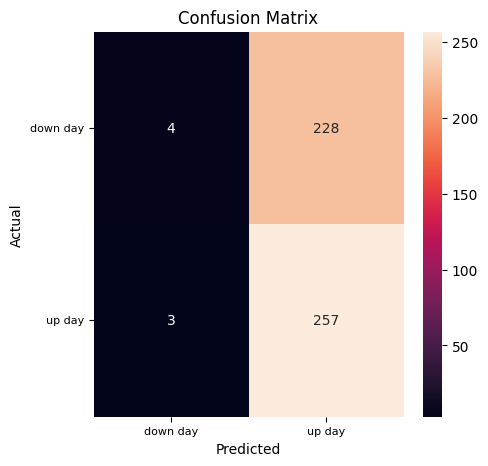

In [42]:
from sklearn.metrics import confusion_matrix

def predict_outcomes(transition_grid, dataset, threshold=0):
    actual = []
    predicted = []
    change_ratio = 100

    for idx in range(len(dataset) - 1):
        current_pattern = dataset['Event_Pattern'].iloc[idx]

        if expected_outcome[current_pattern] > threshold:
            prediction=1
        else:
            prediction=0

        
        

        actual_outcome = dataset['State'].iloc[idx + 1]
        change_outcome = dataset['Close_Gap'].iloc[idx + 1]

        if prediction==1:
            change_ratio = change_ratio * (1+change_outcome)
            # print(change_ratio)
        actual.append(actual_outcome)
        predicted.append(prediction)

    return actual, predicted, change_ratio

# Predict outcomes
actual, predicted, change_ratio = predict_outcomes(grid, validation)

print(f'The final of account balance: {change_ratio}')

# Evaluate predictions
conf_matrix = confusion_matrix(actual, predicted)
print(conf_matrix)

import seaborn as sns

from sklearn.metrics import accuracy_score
score = accuracy_score(actual, [1 if p > 0 else 0 for p in predicted])
print('Accuracy:', round(score * 100,2), '%')

cm = confusion_matrix(actual, [1 if p > 0 else 0 for p in predicted])
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['down day','up day'])
ax.yaxis.set_ticklabels(['down day','up day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 8)  
plt.show()

## Interpretation

The threshhold serves to increase profit, but for initial demonstration the **default value of 0 is used.**

With this method our final balance change is: **%92** loss

From confusion matrix for our prediction, it can be seen that the strategy favors 'buy' prediction much more, caused by general up-trend of Google stock over this period which affected the expected outcome array. While we have %53 accuracy, which when considered an accuracy above %50 be beneficial, this method is not suitable without implementation of threshold. The reason this is important is that for financial situation, false positives will harm the account balance more than false negatives. Thus we create a threshold were we add extra safety on deciding to make a buy position, thus making sure we buy a position when we really expect a positive outcome from our expected outcomes

In [43]:
def best_threshold(transition_grid, dataset, thresholds):
    # Initialize a dictionary to store the change ratio for each threshold
    threshold_dict = {}

    # Iterate over each threshold value
    for threshold in thresholds:
        # Reset the change ratio for each threshold
        change_ratio = 100
        # print(threshold)
        # Iterate over the dataset
        for idx in range(len(dataset) - 1):
            current_pattern = dataset['Event_Pattern'].iloc[idx]
            actual_outcome = dataset['State'].iloc[idx + 1]
            change_outcome = dataset['Close_Gap'].iloc[idx + 1]

            # Make a prediction based on the expected outcome
            prediction = 1 if expected_outcome[current_pattern] > threshold else 0

            # Update the change ratio if the prediction matches the actual outcome
            if prediction == 1:
                change_ratio *= (1 + change_outcome)

        # Store the final change ratio for the threshold
        threshold_dict[threshold] = change_ratio

    return threshold_dict


# Define the range and step size for thresholds
min_value = 0
# max_value=float(max(new_set_df['Close_Gap'].values))
max_value=float(max(expected_outcome))
print(max_value)
step_value = (max_value - min_value) / 50  # This will create 50 intervals within the range

# Generate a list of thresholds with the specified step value
thresholds = [min_value + i * step_value for i in range(51)]  # 51 to include the max_value
best_thresholds = best_threshold(grid, validation, thresholds)
best_thresholds


2.2876165423912873


{0.0: 8.078661048780834,
 0.04575233084782575: 8.777995981905978,
 0.0915046616956515: 6.763694790869885,
 0.13725699254347723: 116.55218684431692,
 0.183009323391303: 116.55218684431692,
 0.22876165423912875: 102.00181400387211,
 0.27451398508695446: 103.19908004983164,
 0.3202663159347802: 103.19908004983164,
 0.366018646782606: 103.19908004983164,
 0.41177097763043174: 109.7298705189083,
 0.4575233084782575: 114.02081760329494,
 0.5032756393260832: 114.02081760329494,
 0.5490279701739089: 114.02081760329494,
 0.5947803010217347: 114.02081760329494,
 0.6405326318695604: 114.02081760329494,
 0.6862849627173863: 114.02081760329494,
 0.732037293565212: 114.02081760329494,
 0.7777896244130377: 114.02081760329494,
 0.8235419552608635: 114.02081760329494,
 0.8692942861086892: 114.02081760329494,
 0.915046616956515: 114.02081760329494,
 0.9607989478043407: 114.02081760329494,
 1.0065512786521664: 114.02081760329494,
 1.0523036094999922: 102.92848573446908,
 1.0980559403478178: 102.928485734

The highest value is 116.55218684431692 and the corresponding threshold is 0.13725699254347723.
[[147  85]
 [171  89]]
Accuracy: 47.97 %


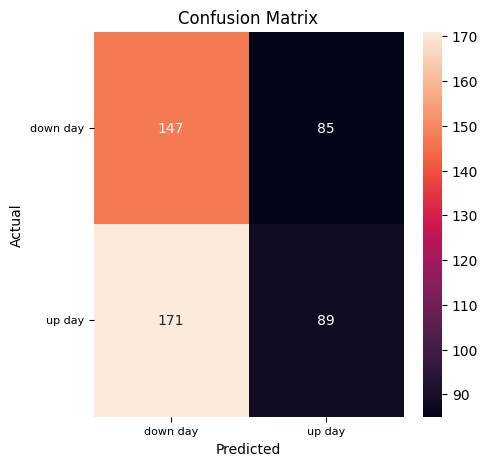

In [44]:
# Assuming best_thresholds is your dictionary with thresholds as keys and change ratios as values
max_value = max(best_thresholds.values())  # Find the maximum value
max_threshold = max(best_thresholds, key=best_thresholds.get)  # Find the key corresponding to the maximum value

# Print the results
print(f"The highest value is {max_value} and the corresponding threshold is {max_threshold}.")

from sklearn.metrics import confusion_matrix

# Predict outcomes
actual, predicted, change_ratio = predict_outcomes(grid, validation, threshold=max_threshold)

# Evaluate predictions
conf_matrix = confusion_matrix(actual, predicted)
print(conf_matrix)

import seaborn as sns

from sklearn.metrics import accuracy_score
score = accuracy_score(actual, predicted)
print('Accuracy:', round(score * 100,2), '%')

cm = confusion_matrix(actual, predicted)
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.xaxis.set_ticklabels(['down day','up day'])
ax.yaxis.set_ticklabels(['down day','up day'])
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0, fontsize = 8)  
plt.show()

## Interpretation

With this method and the best threshold, our final balance change is: **%16** profit

The strategy opens buy position only when the expected outcome is higher than given threshold, thus resulting in less buy decision and more accurate buy decisions that generates considerabe proft.

We used last %10 row of our dataset. While %16 profit is favorable, it doesn't signify good strategy before looking at basic price change for google's price change over the same period:

In [50]:
stock_validation=gspc_df[split_index:]
stock_prices=stock_validation['Close'].values
print("Buying at: ",stock_prices[0]/20)
print("Selling at: ", stock_prices[-1])
print("The profit would be: %",int((stock_prices[-1]-stock_prices[0]/20)/(stock_prices[0]/20)*100))

Buying at:  111.1615
Selling at:  176.4
The profit would be: % 58


Buy and hold strategy would return %58 profit, while our method returned %16 profit, much lower then the hold strategy. This simple markov chain model for this example is not suitable for actual stock market orders, however the key factor for the success of markov chain method is to create the states that can describe the stock market. For example Implementation of reinforcement-learning to create expected states for next step can be beneficial, also the combination of used Indicators can be increased and made more complex, for this method only short, long moving averages and Relative Strength Index (RSI) is used.

**Note for dividing old stock price of google to 20:**

Google's parent company, Alphabet, announced a 20-for-1 stock split in 2022. The stock split occurred on July 18th, 2022¹. This was the first stock split since April 2014 and was intended to make the shares more affordable and appealing to a broader range of investors. Each shareholder received an additional 19 shares for each share they owned at the close of business on July 1, 2022.

(1) Google parent Alphabet announces 20-for-1 stock split - CNBC. https://www.cnbc.com/2022/02/01/google-parent-alphabet-announces-20-for-1-stock-split.html.


# Conclusion:

This notebook creates states for a stock, generates markov chain transition matrix and calculates expected outcome for each state's next step.

This process is pipe-lined, any other stock can be inserted with any time-range to re-create the results.

With this method, the markov chain can easily be repeated, and to increase performance of the strategy, a study on "Event Pattern" must be studied, different patterns can be created using different Technical Indicators or even Fundamental Analysis related patterns can be added if this method was to implemented to not only singular stock but multiple stocks, thus also describing the stocks performance overall in the market.